<a href="https://colab.research.google.com/github/Kasebas/Big_Data/blob/main/IBD26_JuanSebastianLopezRuiz_Actividad1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Limpieza de columnas y tratamiento de tipos de datos

In [ ]:
# %%
# ============================================================
# IBD26 - Introducción al Análisis de Grandes Volúmenes de Datos
# Actividad 1 - Defunciones según causa de muerte (INE)
#
# Notebook adaptado a tus ficheros:
#   - 73573.csv          -> Defunciones según causa de muerte (INE)
#   - poblacion_ccaa.csv -> "Población" por CCAA (nº de municipios, usado como proxy)
#
# En este notebook se incluyen comentarios en lenguaje humano dentro del código,
# explicando qué hace cada bloque y por qué.
# ============================================================

# Importamos las librerías necesarias para análisis de datos, gráficos y modelos.
import pandas as pd          # Manejo de datos en forma de tablas (DataFrame)
import numpy as np           # Operaciones numéricas
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns        # Gráficos estadísticos de más alto nivel

from sklearn.cluster import KMeans          # Algoritmo de clustering
from sklearn.preprocessing import StandardScaler  # Escalado de variables para KMeans
from sklearn.linear_model import LinearRegression  # Regresión lineal

# Indicamos a Jupyter que los gráficos se muestren dentro del notebook.
%matplotlib inline

# Ajustamos algunas opciones de visualización de pandas para ver mejor las tablas.
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

## 2. Valores únicos y corrección de inconsistencias

In [ ]:
# %%
# ============================================================
# 1. CARGA DE DATOS Y LIMPIEZA BÁSICA
#    (lectura de CSV y corrección de codificación)
# ============================================================

# Definimos las rutas a los ficheros CSV. Si el notebook está en la misma carpeta
# que los CSV, basta con el nombre del archivo.
defunciones_csv = "73573.csv"
poblacion_csv   = "poblacion_ccaa.csv"

# Leemos el fichero de defunciones. Usamos separador ';' y codificación 'latin-1'
# porque es el formato típico de los ficheros del INE.
df = pd.read_csv(defunciones_csv, sep=";", encoding="latin-1")

# Leemos el fichero de "población" de CCAA. En realidad contiene número de municipios
# por tamaño, pero en esta práctica lo utilizaremos como una población equivalente.
pob = pd.read_csv(poblacion_csv, sep=";", encoding="latin-1")

# Mostramos una vista rápida de ambos dataframes para comprobar que se han cargado bien.
display(df.head())
display(pob.head())

,ï»¿Causa de muerte,Sexo,Comunidades y Ciudades AutÃ³nomas,Edad,Periodo,Total
0,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2023,436.12
1,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2022,464.42
2,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2021,450.74
3,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2020,493.78
4,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2019,418.70


,Tamaño de los municipios,Comunidades y Ciudades Autónomas,Periodo,Total
0,Menos de 101,01 Andalucía,2021,112
1,Menos de 101,01 Andalucía,2020,109
2,Menos de 101,01 Andalucía,2019,114
3,Menos de 101,01 Andalucía,2018,125
4,Menos de 101,01 Andalucía,2017,118


## 3. Exploración inicial del dataset

In [ ]:
# %%
# ============================================================
# 1 (continuación). ARREGLO DE NOMBRES DE COLUMNAS Y CODIFICACIÓN
# ============================================================

# En el CSV de defunciones, el nombre de la primera columna suele venir con un BOM
# (caracteres raros tipo ï»¿). Además, algunas cadenas pueden estar mal codificadas.
# En este bloque corregimos esos problemas.

# Renombramos las columnas aplicando una función que:
#  - intenta decodificar de latin-1 a utf-8
#  - elimina el BOM inicial si existe
df = df.rename(
    columns=lambda c: (
        c.encode("latin1").decode("utf-8").lstrip("\ufeff") if isinstance(c, str) else c
    )
)

# Definimos una función auxiliar para arreglar texto mal codificado
# (acentos, eñes, etc.). Si la conversión falla, devolvemos el valor original.
def fix_text(s):
    if isinstance(s, str):
        try:
            return s.encode("latin1").decode("utf-8")
        except Exception:
            return s
    return s

# Aplicamos la corrección de texto a las columnas de texto más importantes.
for col in ["Causa de muerte", "Comunidades y Ciudades Autónomas", "Edad"]:
    df[col] = df[col].apply(fix_text)

# Definimos nombres cortos de columnas para trabajar más cómodo.
COL_CAUSA   = "Causa de muerte"
COL_SEXO    = "Sexo"
COL_REGION  = "Comunidades y Ciudades Autónomas"
COL_EDAD    = "Edad"
COL_ANIO    = "Periodo"
COL_DEF     = "Total"

# Comprobamos el listado de columnas resultante tras las correcciones.
print("Columnas del dataset de defunciones:")
print(df.columns)
display(df.head())

Columnas del dataset de defunciones:
Index(['Causa de muerte', 'Sexo', 'Comunidades y Ciudades Autónomas', 'Edad',
       'Periodo', 'Total'],
      dtype='object')


,Causa de muerte,Sexo,Comunidades y Ciudades Autónomas,Edad,Periodo,Total
0,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2023,436.12
1,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2022,464.42
2,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2021,450.74
3,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2020,493.78
4,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2019,418.70


## 4. Distribución gráfica de muertes por sexo y año

In [ ]:
# %%
# ============================================================
# 1 (continuación). LIMPIEZA DE LA COLUMNA NUMÉRICA DE DEFUNCIONES
# ============================================================

# La columna 'Total' (número de defunciones) puede venir con separadores de miles,
# por ejemplo '436.124'. Nuestro objetivo es dejarla como número entero.
# Para ello:
#   1) Forzamos a string
#   2) Eliminamos el punto de miles
#   3) Sustituimos comas por puntos (en caso de decimales)
#   4) Convertimos a tipo numérico (int/float)

# Aseguramos que la columna se trata como string
df[COL_DEF] = df[COL_DEF].astype(str)

# Eliminamos los puntos de miles
df[COL_DEF] = df[COL_DEF].str.replace(".", "", regex=False)

# Reemplazamos comas por puntos, por si existieran decimales
df[COL_DEF] = df[COL_DEF].str.replace(",", ".", regex=False)

# Convertimos finalmente a numérico. 'errors="coerce"' pone NaN si algo no se puede convertir.
df[COL_DEF] = pd.to_numeric(df[COL_DEF], errors="coerce")

# También convertimos el año a numérico para poder hacer filtros y gráficas por año.
df[COL_ANIO] = pd.to_numeric(df[COL_ANIO], errors="coerce")

print("Tipos de datos después de la limpieza numérica:")
print(df.dtypes)
display(df.head())

Tipos de datos después de la limpieza numérica:
Causa de muerte                      object
Sexo                                 object
Comunidades y Ciudades Autónomas     object
Edad                                 object
Periodo                               int64
Total                               float64
dtype: object


,Causa de muerte,Sexo,Comunidades y Ciudades Autónomas,Edad,Periodo,Total
0,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2023,"436,124.00"
1,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2022,"464,417.00"
2,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2021,"450,744.00"
3,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2020,"493,776.00"
4,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2019,"418,703.00"


## 5. Evolución temporal de una enfermedad concreta

In [ ]:
# %%
# ============================================================
# 2. VALORES ÚNICOS Y POSIBLES DUPLICADOS DE ESCRITURA
# ============================================================

# En este apartado inspeccionamos los valores únicos de las columnas categóricas
# (CCAA, sexo, edad, causa de muerte). Esto nos permite detectar:
#   - errores ortográficos (ej. 'Andalucia' sin tilde)
#   - espacios en blanco
#   - codificaciones extrañas
# Aunque en este dataset vienen bastante limpios, es buena práctica revisarlos.

for col in [COL_REGION, COL_SEXO, COL_EDAD, COL_CAUSA]:
    print(f"\nValores únicos en la columna '{col}' (muestra):")
    print(df[col].unique()[:30])  # mostramos hasta 30 valores para no saturar la salida

# Aquí podríamos corregir manualmente errores si los hubiera. Ejemplo de plantilla:
# df[COL_REGION] = df[COL_REGION].replace({
#     "Andalucia": "01 Andalucía",
#     "Andalicia": "01 Andalucía"
# })

print("\nListado de regiones (CCAA) distintas:")
print(sorted(df[COL_REGION].unique()))


Valores únicos en la columna 'Comunidades y Ciudades Autónomas' (muestra):
['Nacional' '01 Andalucía' '02 Aragón' '03 Asturias, Principado de'
 '04 Balears, Illes' '05 Canarias' '06 Cantabria' '07 Castilla y León'
 '08 Castilla - La Mancha' '09 Cataluña' '10 Comunitat Valenciana'
 '11 Extremadura' '12 Galicia' '13 Madrid, Comunidad de'
 '14 Murcia, Región de' '15 Navarra, Comunidad Foral de' '16 País Vasco'
 '17 Rioja, La' '18 Ceuta' '19 Melilla' 'Extranjero']

Valores únicos en la columna 'Sexo' (muestra):
['Total' 'Hombres' 'Mujeres']

Valores únicos en la columna 'Edad' (muestra):
['Todas las edades' 'Menos de 1 año' 'De 1 a 14 años' 'De 15 a 29 años'
 'De 30 a 39 años' 'De 40 a 44 años' 'De 45 a 49 años' 'De 50 a 54 años'
 'De 55 a 59 años' 'De 60 a 64 años' 'De 65 a 69 años' 'De 70 a 74 años'
 'De 75 a 79 años' 'De 80 a 84 años' 'De 85 a 89 años' 'De 90 a 94 años'
 '95 y más años']

Valores únicos en la columna 'Causa de muerte' (muestra):
['001-102  I-XXII.Todas las causas'
 '00

## 6. Heatmap de muertes por CCAA en 2023

In [ ]:
# %%
# ============================================================
# 3. EXPLORACIÓN INICIAL DEL DATASET
# ============================================================

# En este bloque hacemos una exploración rápida del dataset:
#   - Dimensiones (nº de filas y columnas)
#   - Información general de tipos de datos
#   - Estadísticos básicos de la columna de defunciones
#   - Primeras y últimas filas
#   - Conteo de valores nulos por columna
# Esto nos ayuda a tener una primera impresión de la calidad de los datos.

print("Dimensiones del dataset (filas, columnas):", df.shape)

print("\nInformación general del DataFrame:")
df.info()

print("\nDescripción estadística de la columna de defunciones:")
print(df[COL_DEF].describe())

print("\nPrimeras 10 filas del dataset:")
display(df.head(10))

print("\nÚltimas 10 filas del dataset:")
display(df.tail(10))

print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

Dimensiones del dataset (filas, columnas): (377032, 6)

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377032 entries, 0 to 377031
Data columns (total 6 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Causa de muerte                   377032 non-null  object 
 1   Sexo                              377032 non-null  object 
 2   Comunidades y Ciudades Autónomas  377032 non-null  object 
 3   Edad                              377032 non-null  object 
 4   Periodo                           377032 non-null  int64  
 5   Total                             377031 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 17.3+ MB

Descripción estadística de la columna de defunciones:
count   377,031.00
mean      1,234.60
std       5,919.43
min           0.00
25%          10.00
50%         120.00
75%       1,011.00
max     493,776.00
Name: Total, dtyp

,Causa de muerte,Sexo,Comunidades y Ciudades Autónomas,Edad,Periodo,Total
0,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2023,"436,124.00"
1,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2022,"464,417.00"
2,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2021,"450,744.00"
3,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2020,"493,776.00"
4,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2019,"418,703.00"
5,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2018,"427,721.00"
6,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2017,"424,523.00"
7,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2016,"410,611.00"
8,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2015,"422,568.00"
9,001-102 I-XXII.Todas las causas,Total,Nacional,Todas las edades,2014,"39,583.00"



Últimas 10 filas del dataset:


,Causa de muerte,Sexo,Comunidades y Ciudades Autónomas,Edad,Periodo,Total
377022,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1993,"33,545.00"
377023,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1992,"31,292.00"
377024,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1991,"32,994.00"
377025,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1990,"34,199.00"
377026,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1989,"31,048.00"
377027,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1988,"29,513.00"
377028,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1987,"27,975.00"
377029,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1986,"29,398.00"
377030,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1985,"30,464.00"
377031,062-067 X.Enfermedades del sistema respiratorio,Total,Nacional,Todas las edades,1984,NaN



Conteo de valores nulos por columna:
Causa de muerte                     0
Sexo                                0
Comunidades y Ciudades Autónomas    0
Edad                                0
Periodo                             0
Total                               1
dtype: int64


## 7. Comparación de muertes por rango de edad y causa

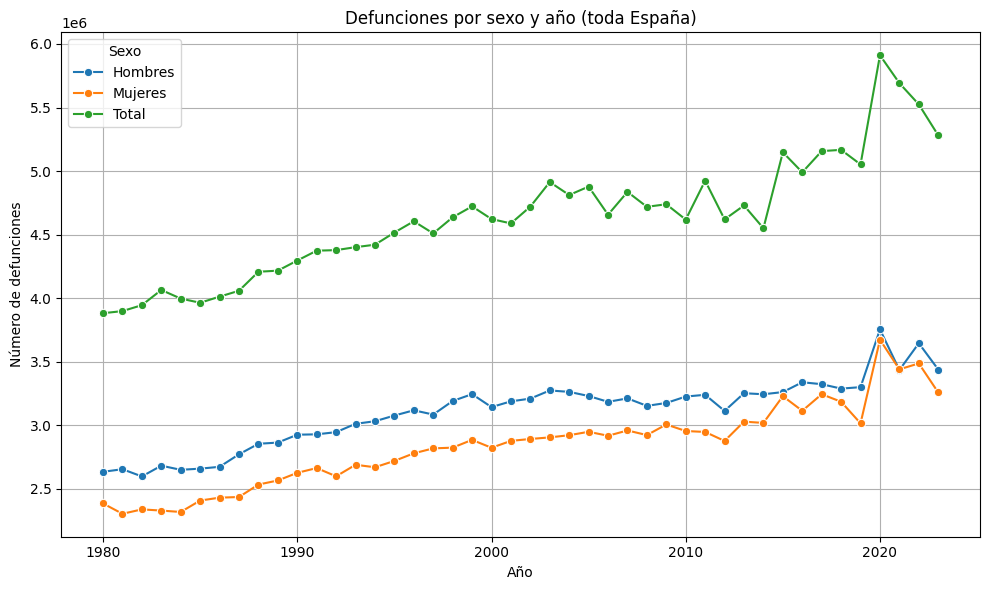

,Periodo,Sexo,Total
0,1980,Hombres,"2,634,691.00"
1,1980,Mujeres,"2,385,619.00"
2,1980,Total,"3,882,197.00"
3,1981,Hombres,"2,654,969.00"
4,1981,Mujeres,"2,304,305.00"


In [ ]:
# %%
# ============================================================
# 4. DISTRIBUCIÓN GRÁFICA DE MUERTES POR SEXO Y AÑO
# ============================================================

# Objetivo: visualizar cómo evolucionan las defunciones en el tiempo,
# diferenciando entre hombres y mujeres.
# Pasos:
#   1) Agrupamos por año y sexo, sumando el total de defunciones.
#   2) Representamos una gráfica de líneas para cada sexo.

# Agrupamos los datos por año y sexo
df_sexo_anio = (
    df.groupby([COL_ANIO, COL_SEXO])[COL_DEF]
      .sum()
      .reset_index()
)

# Creamos la gráfica de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sexo_anio, x=COL_ANIO, y=COL_DEF, hue=COL_SEXO, marker="o")
plt.title("Defunciones por sexo y año (toda España)")
plt.xlabel("Año")
plt.ylabel("Número de defunciones")
plt.grid(True)
plt.tight_layout()
plt.show()

display(df_sexo_anio.head())

## 8. Top 10 de muertes en Andalucía por sexo (2012–2022)

Ejemplos de causas de muerte presentes en el dataset:
- 001-102  I-XXII.Todas las causas
- 001-008  I.Enfermedades infecciosas y parasitarias
- 009-041  II.Tumores
- 042-043  III.Enfermedades de la sangre y de los órganos hematopoyéticos, y ciertos trastornos que afectan al mecanismo de la inmunidad
- 044-045  IV.Enfermedades endocrinas, nutricionales y metabólicas
- 046-049  V.Trastornos mentales y del comportamiento
- 050-052  VI-VIII.Enfermedades del sistema nervioso y de los órganos de los sentidos
- 053-061 IX.Enfermedades del sistema circulatorio
- 062-067  X.Enfermedades del sistema respiratorio


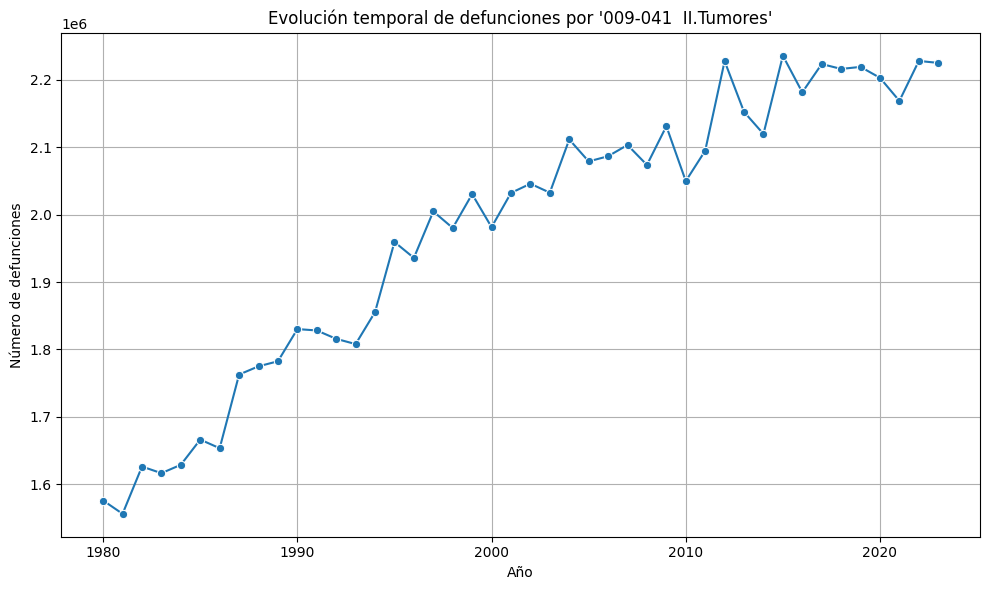

,Periodo,Total
0,1980,"1,576,045.00"
1,1981,"1,556,309.00"
2,1982,"1,626,397.00"
3,1983,"1,616,572.00"
4,1984,"1,629,012.00"


In [ ]:
# %%
# ============================================================
# 5. EVOLUCIÓN TEMPORAL DE UNA ENFERMEDAD CONCRETA
# ============================================================

# En este apartado elegimos una causa de muerte específica y
# analizamos cómo varía a lo largo de los años.
# Para ello:
#   1) Mostramos algunas causas disponibles en el dataset.
#   2) Escogemos una causa por su código/nombre.
#   3) Sumamos las defunciones por año para esa causa y las graficamos.

# Mostramos algunas causas de muerte para orientarnos
print("Ejemplos de causas de muerte presentes en el dataset:")
for c in df[COL_CAUSA].unique()[:15]:
    print("-", c)

# Definimos la causa que vamos a estudiar (puedes cambiarla si lo deseas).
causa_seleccionada = "009-041  II.Tumores"

# Filtramos por esa causa y agregamos por año
df_causa = (
    df[df[COL_CAUSA] == causa_seleccionada]
    .groupby(COL_ANIO)[COL_DEF]
    .sum()
    .reset_index()
    .sort_values(COL_ANIO)
)

# Graficamos la evolución temporal de las defunciones por esa causa
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_causa, x=COL_ANIO, y=COL_DEF, marker="o")
plt.title(f"Evolución temporal de defunciones por '{causa_seleccionada}'")
plt.xlabel("Año")
plt.ylabel("Número de defunciones")
plt.grid(True)
plt.tight_layout()
plt.show()

display(df_causa.head())

## 9. Matriz CCAA × causa + clustering KMeans

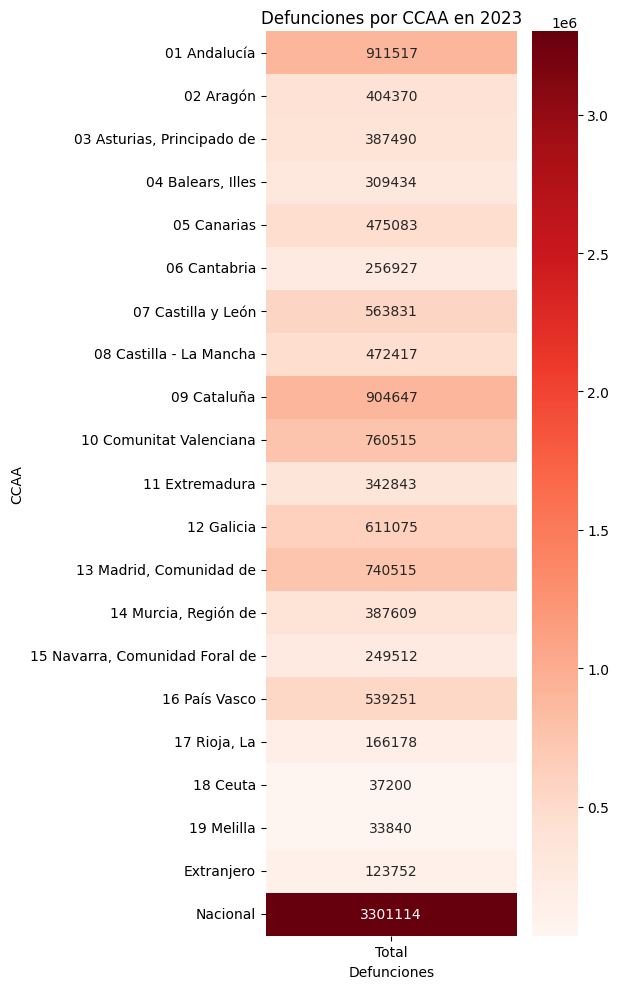

,Comunidades y Ciudades Autónomas,Total
20,Nacional,"3,301,114.00"
0,01 Andalucía,"911,517.00"
8,09 Cataluña,"904,647.00"
9,10 Comunitat Valenciana,"760,515.00"
12,"13 Madrid, Comunidad de","740,515.00"


In [ ]:
# %%
# ============================================================
# 6. HEATMAP DE MUERTES POR CCAA EN 2023
# ============================================================

# Aquí queremos ver qué comunidades autónomas han tenido más defunciones en 2023.
# Pasos:
#   1) Filtrar el año 2023.
#   2) Agregar por CCAA (sumando todas las causas, edades y sexos).
#   3) Dibujar un mapa de calor usando una tabla (heatmap).

anio_heatmap = 2023

# Filtramos y agregamos por CCAA
df_2023 = (
    df[df[COL_ANIO] == anio_heatmap]
    .groupby(COL_REGION)[COL_DEF]
    .sum()
    .reset_index()
)

# Preparamos los datos para el heatmap: índice = CCAA, columna = Total defunciones
heat_data = df_2023.set_index(COL_REGION)[[COL_DEF]]

# Dibujamos el heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(heat_data, annot=True, fmt=".0f", cmap="Reds")
plt.title(f"Defunciones por CCAA en {anio_heatmap}")
plt.xlabel("Defunciones")
plt.ylabel("CCAA")
plt.tight_layout()
plt.show()

display(df_2023.sort_values(COL_DEF, ascending=False).head())

## 10. Unión con dataset de población y tasas de mortalidad

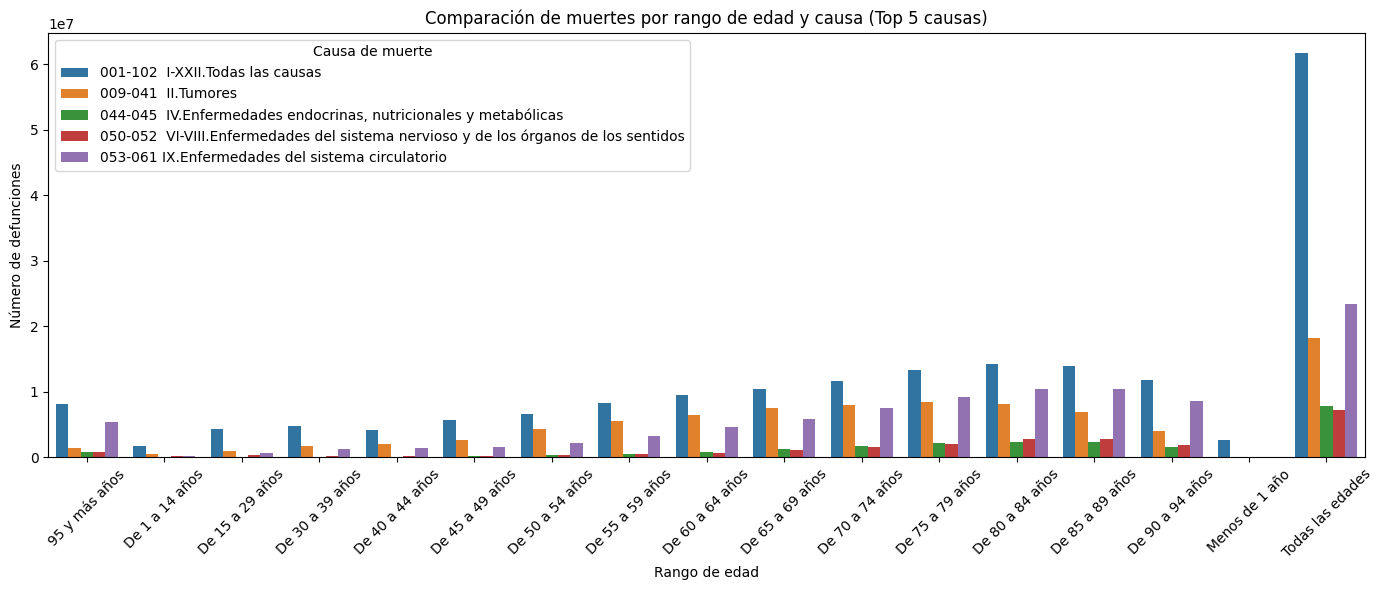

,Edad,Causa de muerte,Total
1,95 y más años,001-102 I-XXII.Todas las causas,"8,108,052.00"
2,95 y más años,009-041 II.Tumores,"1,424,668.00"
4,95 y más años,"044-045 IV.Enfermedades endocrinas, nutricion...","792,610.00"
6,95 y más años,050-052 VI-VIII.Enfermedades del sistema nerv...,"767,993.00"
7,95 y más años,053-061 IX.Enfermedades del sistema circulatorio,"5,402,440.00"


In [ ]:
# %%
# ============================================================
# 7. COMPARACIÓN DE MUERTES POR RANGO DE EDAD Y CAUSA
# ============================================================

# En este punto queremos ver qué causas de muerte son más importantes
# en cada grupo de edad.
# Procedimiento:
#   1) Agregar defunciones por combinación (rango de edad, causa de muerte).
#   2) Calcular el total por causa para quedarnos con las más frecuentes.
#   3) Mostrar un gráfico de barras agrupado por edad y causa (para las top).

# Agregamos defunciones por edad y causa de muerte
df_edad_causa = (
    df.groupby([COL_EDAD, COL_CAUSA])[COL_DEF]
      .sum()
      .reset_index()
)

# Obtenemos las 5 causas con más defunciones totales
top_causas = (
    df_edad_causa.groupby(COL_CAUSA)[COL_DEF]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filtramos la tabla solo a esas causas principales
df_edad_causa_top = df_edad_causa[df_edad_causa[COL_CAUSA].isin(top_causas)]

# Representamos el gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_edad_causa_top,
    x=COL_EDAD,
    y=COL_DEF,
    hue=COL_CAUSA
)
plt.title("Comparación de muertes por rango de edad y causa (Top 5 causas)")
plt.xlabel("Rango de edad")
plt.ylabel("Número de defunciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(df_edad_causa_top.head())

## 11. Top 10 CCAA con más muertes por población en 2024

In [ ]:
# %%
# ============================================================
# 8. TOP 10 CAUSAS CON MÁS MUERTES EN ANDALUCÍA POR SEXO (2012–2022)
# ============================================================

# El objetivo es ver, para la comunidad de Andalucía, cuáles han sido
# las 10 causas de muerte más frecuentes en el periodo 2012–2022,
# separando hombres y mujeres.
# Pasos:
#   1) Filtrar por CCAA = "01 Andalucía".
#   2) Filtrar años entre 2012 y 2022.
#   3) Agregar por sexo y causa.
#   4) Ordenar y quedarse con el top 10 para cada sexo.

# Definimos la región de interés según aparece en el CSV del INE.
region_objetivo = "01 Andalucía"

# Filtramos para quedarnos solo con Andalucía y el rango de años requerido
df_andalucia = df[
    (df[COL_REGION] == region_objetivo) &
    (df[COL_ANIO] >= 2012) &
    (df[COL_ANIO] <= 2022)
]

# Agrupamos por sexo y causa de muerte
df_andalucia_sexo_causa = (
    df_andalucia
    .groupby([COL_SEXO, COL_CAUSA])[COL_DEF]
    .sum()
    .reset_index()
)

# Obtenemos el Top 10 para HOMBRES
top10_hombres = (
    df_andalucia_sexo_causa[df_andalucia_sexo_causa[COL_SEXO] == "Hombres"]
    .sort_values(COL_DEF, ascending=False)
    .head(10)
)

# Obtenemos el Top 10 para MUJERES
top10_mujeres = (
    df_andalucia_sexo_causa[df_andalucia_sexo_causa[COL_SEXO] == "Mujeres"]
    .sort_values(COL_DEF, ascending=False)
    .head(10)
)

print("Top 10 causas de muerte en Andalucía para HOMBRES (2012–2022):")
display(top10_hombres)

print("\nTop 10 causas de muerte en Andalucía para MUJERES (2012–2022):")
display(top10_mujeres)

Top 10 causas de muerte en Andalucía para HOMBRES (2012–2022):


,Sexo,Causa de muerte,Total
1,Hombres,001-102 I-XXII.Todas las causas,"976,494.00"
7,Hombres,053-061 IX.Enfermedades del sistema circulatorio,"543,050.00"
2,Hombres,009-041 II.Tumores,"484,255.00"
0,Hombres,001-008 I.Enfermedades infecciosas y parasita...,"225,655.00"
6,Hombres,050-052 VI-VIII.Enfermedades del sistema nerv...,"191,888.00"
5,Hombres,046-049 V.Trastornos mentales y del comportam...,"186,580.00"
4,Hombres,"044-045 IV.Enfermedades endocrinas, nutricion...","174,248.00"
3,Hombres,042-043 III.Enfermedades de la sangre y de lo...,"30,780.00"



Top 10 causas de muerte en Andalucía para MUJERES (2012–2022):


,Sexo,Causa de muerte,Total
9,Mujeres,001-102 I-XXII.Todas las causas,"963,021.00"
10,Mujeres,009-041 II.Tumores,"657,312.00"
15,Mujeres,053-061 IX.Enfermedades del sistema circulatorio,"424,688.00"
14,Mujeres,050-052 VI-VIII.Enfermedades del sistema nerv...,"296,060.00"
8,Mujeres,001-008 I.Enfermedades infecciosas y parasita...,"201,983.00"
13,Mujeres,046-049 V.Trastornos mentales y del comportam...,"189,011.00"
12,Mujeres,"044-045 IV.Enfermedades endocrinas, nutricion...","153,967.00"
11,Mujeres,042-043 III.Enfermedades de la sangre y de lo...,"36,880.00"


## 12. Regresión lineal y predicción para los próximos 5 años

Matriz CCAA × causa de muerte con cluster KMeans (k=4) - año 2023:


Causa de muerte,001-008 I.Enfermedades infecciosas y parasitarias,001-102 I-XXII.Todas las causas,009-041 II.Tumores,"042-043 III.Enfermedades de la sangre y de los órganos hematopoyéticos, y ciertos trastornos que afectan al mecanismo de la inmunidad","044-045 IV.Enfermedades endocrinas, nutricionales y metabólicas",046-049 V.Trastornos mentales y del comportamiento,050-052 VI-VIII.Enfermedades del sistema nervioso y de los órganos de los sentidos,053-061 IX.Enfermedades del sistema circulatorio,062-067 X.Enfermedades del sistema respiratorio,cluster
Comunidades y Ciudades Autónomas,,,,,,,,,,
01 Andalucía,"49,163.00","338,348.00","148,670.00","13,240.00","55,034.00","71,461.00","86,939.00","148,662.00",0.00,0
12 Galicia,"31,003.00","175,282.00","140,929.00","5,920.00","33,418.00","63,836.00","49,321.00","111,366.00",0.00,0
10 Comunitat Valenciana,"45,539.00","241,146.00","155,164.00","9,760.00","53,927.00","48,134.00","71,566.00","135,279.00",0.00,0
09 Cataluña,"51,414.00","321,372.00","162,758.00","13,720.00","54,252.00","71,176.00","83,333.00","146,622.00",0.00,0
"13 Madrid, Comunidad de","53,723.00","238,243.00","167,107.00","9,440.00","32,023.00","58,541.00","58,345.00","123,093.00",0.00,0
"04 Balears, Illes","11,640.00","138,038.00","54,670.00","2,080.00","15,720.00","16,080.00","22,520.00","48,686.00",0.00,1
06 Cantabria,"7,960.00","110,906.00","51,739.00","1,240.00","9,000.00","15,480.00","14,040.00","46,562.00",0.00,1
11 Extremadura,"17,160.00","140,565.00","62,348.00","2,800.00","15,440.00","17,120.00","18,440.00","68,970.00",0.00,1
"15 Navarra, Comunidad Foral de","6,440.00","107,070.00","47,027.00","1,360.00","7,560.00","17,760.00","18,120.00","44,175.00",0.00,1


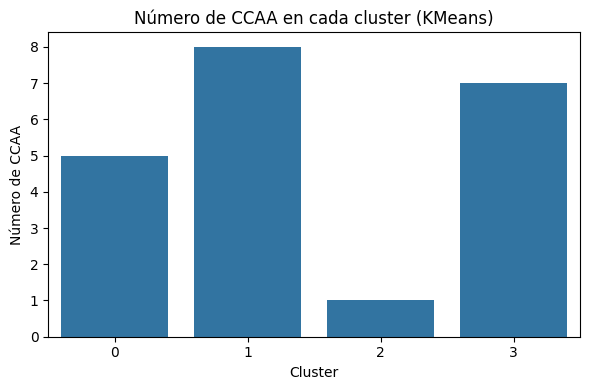

In [ ]:
# %%
# ============================================================
# 9. MATRIZ CCAA × CAUSA DE MUERTE + CLUSTERING KMEANS
# ============================================================

# En este apartado construimos una matriz donde:
#   - Cada fila es una Comunidad Autónoma.
#   - Cada columna es una causa de muerte.
#   - El valor es el número de defunciones.
# Sobre esa matriz aplicamos KMeans para agrupar CCAA con perfiles
# de mortalidad parecidos.
# Para simplificar, usamos los datos de un solo año (2023).

anio_kmeans = 2023

# Filtramos por el año elegido y agregamos por CCAA y causa
df_kmeans = (
    df[df[COL_ANIO] == anio_kmeans]
    .groupby([COL_REGION, COL_CAUSA])[COL_DEF]
    .sum()
    .reset_index()
)

# Creamos la matriz: filas = CCAA, columnas = causa de muerte
matriz = df_kmeans.pivot_table(
    index=COL_REGION,
    columns=COL_CAUSA,
    values=COL_DEF,
    fill_value=0  # si no hay defunciones para esa causa, ponemos 0
)

# Antes de aplicar KMeans, escalamos las variables para que todas
# tengan un rango comparable.
scaler = StandardScaler()
matriz_escalada = scaler.fit_transform(matriz)

# Definimos el número de clusters k. Usamos k=4 como ejemplo razonable.
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(matriz_escalada)

# Añadimos el número de cluster asignado a cada CCAA.
matriz_clusters = matriz.copy()
matriz_clusters["cluster"] = clusters

print(f"Matriz CCAA × causa de muerte con cluster KMeans (k={k}) - año {anio_kmeans}:")
display(matriz_clusters.sort_values("cluster"))

# Contamos cuántas CCAA hay en cada cluster
cluster_counts = matriz_clusters["cluster"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title("Número de CCAA en cada cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Número de CCAA")
plt.tight_layout()
plt.show()

In [ ]:
# %%
# ============================================================
# 10. UNIÓN CON DATASET DE "POBLACIÓN" Y CÁLCULO DE TASAS
# ============================================================
# El enunciado pide unir el dataset de defunciones con uno de población
# para obtener tasas de mortalidad (muertes por habitante).
# En nuestro caso, el fichero de población realmente tiene número de
# municipios por CCAA y tamaño, pero lo vamos a usar como si fuera
# una población equivalente.
#
# Estrategia:
#   1) Del fichero de población nos quedamos con el último año disponible
#      y sumamos por CCAA -> "población actual".
#   2) Asumimos que esa población es constante en todos los años de defunciones.
#   3) Calculamos tasa = defunciones / población * 100000.

print("Columnas del dataset de población:")
print(pob.columns)
display(pob.head())

# Definimos los nombres de columnas relevantes en el dataset de población
COL_POB_REGION = "Comunidades y Ciudades Autónomas"
COL_POB_ANIO   = "Periodo"
COL_POB_VALOR  = "Total"   # aquí es nº de municipios, usado como proxy de población

# 1) Obtenemos el último año disponible en el dataset de población
ultimo_anio_pob = pob[COL_POB_ANIO].max()

# Calculamos "población actual" por CCAA para ese año
pob_actual = (
    pob[pob[COL_POB_ANIO] == ultimo_anio_pob]
    .groupby(COL_POB_REGION)[COL_POB_VALOR]
    .sum()
    .reset_index()
    .rename(columns={COL_POB_VALOR: "Poblacion"})
)

# Aseguramos que la columna Poblacion es numérica
pob_actual["Poblacion"] = pd.to_numeric(pob_actual["Poblacion"], errors="coerce")

print(f"Población 'actual' por CCAA (año {ultimo_anio_pob}):")
display(pob_actual.head())

# 2) Agregamos defunciones totales por CCAA y año
df_muertes_anuales = (
    df.groupby([COL_REGION, COL_ANIO])[COL_DEF]
      .sum()
      .reset_index()
)

# Obtenemos los años que hay en el dataset de defunciones
anios_def = df_muertes_anuales[COL_ANIO].unique()

# Generamos un DataFrame con todas las combinaciones CCAA × año,
# asignando a cada una la misma "población actual" de esa CCAA.
regiones = pob_actual[COL_POB_REGION].unique()
pob_expand_rows = []

for region in regiones:
    # Recuperamos la población de esa CCAA
    pop_val = pob_actual.loc[pob_actual[COL_POB_REGION] == region, "Poblacion"].values[0]
    for anio in anios_def:
        pob_expand_rows.append(
            {COL_REGION: region, COL_ANIO: anio, "Poblacion": pop_val}
        )

pob_expand = pd.DataFrame(pob_expand_rows)

# Aseguramos que Poblacion en pob_expand también es numérica
pob_expand["Poblacion"] = pd.to_numeric(pob_expand["Poblacion"], errors="coerce")

print("Ejemplo de población expandida (misma población para todos los años):")
display(pob_expand.head())

# 3) Unimos defunciones anuales con la población expandida
df_tasas = df_muertes_anuales.merge(
    pob_expand,
    on=[COL_REGION, COL_ANIO],
    how="left"
)

# Aseguramos tipos numéricos antes de la operación de división
df_tasas["Poblacion"] = pd.to_numeric(df_tasas["Poblacion"], errors="coerce")
df_tasas[COL_DEF]     = pd.to_numeric(df_tasas[COL_DEF], errors="coerce")

# Calculamos la tasa de defunciones por 100.000 habitantes (o equivalente)
df_tasas["tasa_por_100k"] = df_tasas[COL_DEF] / df_tasas["Poblacion"] * 100000

print("Tabla de muertes y tasas por población (muestra):")
display(df_tasas.head())

# Nos quedamos con los últimos 10 años disponibles
max_anio_def = df_tasas[COL_ANIO].max()
anios_ultimos_10 = list(range(max_anio_def - 9, max_anio_def + 1))

df_tasas_10 = df_tasas[df_tasas[COL_ANIO].isin(anios_ultimos_10)]

print(f"\nTasas de muertes por población en los últimos 10 años (hasta {max_anio_def}):")
display(df_tasas_10.head())


Columnas del dataset de población:
Index(['Tamaño de los municipios', 'Comunidades y Ciudades Autónomas',
       'Periodo', 'Total'],
      dtype='object')


,Tamaño de los municipios,Comunidades y Ciudades Autónomas,Periodo,Total
0,Menos de 101,01 Andalucía,2021,112
1,Menos de 101,01 Andalucía,2020,109
2,Menos de 101,01 Andalucía,2019,114
3,Menos de 101,01 Andalucía,2018,125
4,Menos de 101,01 Andalucía,2017,118


Población 'actual' por CCAA (año 2021):


,Comunidades y Ciudades Autónomas,Poblacion
0,01 Andalucía,NaN
1,02 Aragón,NaN
2,"03 Asturias, Principado de",NaN
3,"04 Balears, Illes",NaN
4,05 Canarias,NaN


Ejemplo de población expandida (misma población para todos los años):


,Comunidades y Ciudades Autónomas,Periodo,Poblacion
0,01 Andalucía,1980,NaN
1,01 Andalucía,1981,NaN
2,01 Andalucía,1982,NaN
3,01 Andalucía,1983,NaN
4,01 Andalucía,1984,NaN


Tabla de muertes y tasas por población (muestra):


,Comunidades y Ciudades Autónomas,Periodo,Total,Poblacion,tasa_por_100k
0,01 Andalucía,1980,"723,804.00",NaN,NaN
1,01 Andalucía,1981,"734,633.00",NaN,NaN
2,01 Andalucía,1982,"703,340.00",NaN,NaN
3,01 Andalucía,1983,"687,036.00",NaN,NaN
4,01 Andalucía,1984,"710,494.00",NaN,NaN



Tasas de muertes por población en los últimos 10 años (hasta 2023):


,Comunidades y Ciudades Autónomas,Periodo,Total,Poblacion,tasa_por_100k
34,01 Andalucía,2014,"846,616.00",NaN,NaN
35,01 Andalucía,2015,"891,172.00",NaN,NaN
36,01 Andalucía,2016,"888,610.00",NaN,NaN
37,01 Andalucía,2017,"912,296.00",NaN,NaN
38,01 Andalucía,2018,"881,154.00",NaN,NaN


In [ ]:
# %%
# ============================================================
# 11. TOP 10 CCAA CON MÁS MUERTES POR POBLACIÓN EN 2024
# ============================================================

# Ahora queremos obtener las comunidades con mayor tasa de mortalidad en 2024.
# Sin embargo, nuestro dataset de defunciones solo llega hasta cierto año
# (probablemente 2023). Si no hay datos para 2024, lo indicaremos.
anio_top = 2024

# Filtramos las tasas para el año 2024
df_2024_tasas = df_tasas[df_tasas[COL_ANIO] == anio_top].copy()

if df_2024_tasas.empty:
    # Caso en el que no hay datos de 2024
    print(f"No hay datos de defunciones para el año {anio_top} en el CSV actual.")
    print("Por tanto, no es posible calcular el Top 10 real de CCAA con más muertes por población.")
else:
    # Si hubiera datos de 2024, ordenamos por tasa y mostramos el Top 10
    top10_tasas_2024 = (
        df_2024_tasas
        .sort_values("tasa_por_100k", ascending=False)
        .head(10)
    )
    print(f"Top 10 CCAA con más muertes por población en {anio_top}:")
    display(top10_tasas_2024[[COL_REGION, "tasa_por_100k", COL_DEF, "Poblacion"]])

No hay datos de defunciones para el año 2024 en el CSV actual.
Por tanto, no es posible calcular el Top 10 real de CCAA con más muertes por población.


Datos agregados por año para la causa seleccionada:


,Periodo,Total
0,1980,"1,576,045.00"
1,1981,"1,556,309.00"
2,1982,"1,626,397.00"
3,1983,"1,616,572.00"
4,1984,"1,629,012.00"



Predicción de defunciones para los próximos 5 años:


,Periodo,prediccion_defunciones
0,2024,2327973
1,2025,2343646
2,2026,2359319
3,2027,2374993
4,2028,2390666


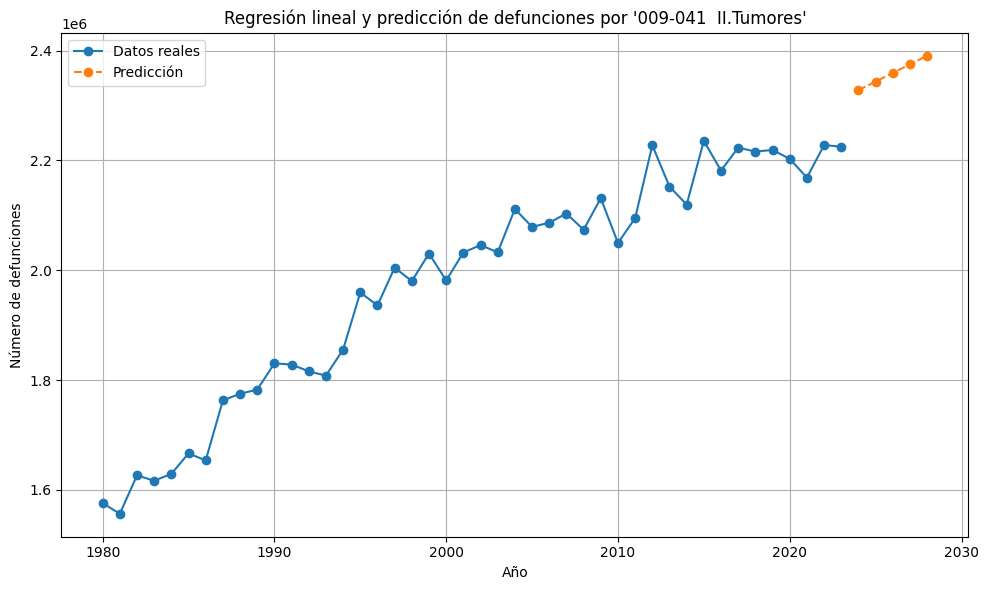

In [ ]:
# %%
# ============================================================
# 12. REGRESIÓN LINEAL Y PREDICCIÓN PARA LOS PRÓXIMOS 5 AÑOS
# ============================================================

# Finalmente, realizamos una regresión lineal sobre una causa de muerte
# concreta para ver su tendencia en el tiempo y predecir los próximos 5 años.
#
# Pasos:
#   1) Seleccionamos una causa de muerte (la misma que antes, por coherencia).
#   2) Agregamos defunciones totales por año para esa causa.
#   3) Entrenamos un modelo de regresión lineal (año -> nº defunciones).
#   4) Predecimos las defunciones para los 5 años posteriores al último año observado.
#   5) Representamos en una gráfica los datos reales y las predicciones.

# Volvemos a usar la causa "009-041  II.Tumores"
causa_regresion = "009-041  II.Tumores"

# Agregamos las defunciones de esa causa por año
df_causa_reg = (
    df[df[COL_CAUSA] == causa_regresion]
    .groupby(COL_ANIO)[COL_DEF]
    .sum()
    .reset_index()
    .sort_values(COL_ANIO)
)

print("Datos agregados por año para la causa seleccionada:")
display(df_causa_reg.head())

# Preparamos las variables de entrada (X = años) y salida (y = defunciones)
X = df_causa_reg[[COL_ANIO]].values
y = df_causa_reg[COL_DEF].values

# Creamos y entrenamos el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X, y)

# Determinamos el último año observado en el dataset
ultimo_anio_observado = df_causa_reg[COL_ANIO].max()

# Generamos una lista con los próximos 5 años
anios_futuros = np.arange(ultimo_anio_observado + 1, ultimo_anio_observado + 6)
X_futuro = anios_futuros.reshape(-1, 1)

# Obtenemos la predicción de defunciones para esos años
y_pred = modelo.predict(X_futuro)

# Creamos un DataFrame para visualizar claramente las predicciones
df_pred = pd.DataFrame({
    COL_ANIO: anios_futuros,
    "prediccion_defunciones": y_pred.astype(int)  # convertimos a entero para interpretación
})

print("\nPredicción de defunciones para los próximos 5 años:")
display(df_pred)

# Representamos tanto los datos históricos como las predicciones en una misma gráfica
plt.figure(figsize=(10, 6))
plt.plot(df_causa_reg[COL_ANIO], df_causa_reg[COL_DEF], marker="o", label="Datos reales")
plt.plot(df_pred[COL_ANIO], df_pred["prediccion_defunciones"], marker="o", linestyle="--", label="Predicción")
plt.title(f"Regresión lineal y predicción de defunciones por '{causa_regresion}'")
plt.xlabel("Año")
plt.ylabel("Número de defunciones")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()